# Degree-Aware Compositional Model

## Research Questions

1. **Does degree stratification improve compositional model fit?**
2. **How much of the conditional structure is explained by degree heterogeneity alone?**
3. **Can degree-aware priors reduce PMI and improve predictions?**

## Approach

### Naive Compositional Model
$$P(C \to P) = \sum_{g} P(C \to g) \times P(g \to P)$$

Assumes independence regardless of degrees.

### Degree-Aware Compositional Model
$$P(C \to P | \text{deg}(C)=u, \text{deg}(P)=v) = \sum_{g: \text{deg}(g)=w} P(C \to g | u, w) \times P(g \to P | w, v)$$

Stratifies by node degrees before applying compositional assumptions.

## Key Hypothesis from Notebook 11

Since Hetionet and null networks have identical PMI distributions (p=0.715), the conditional structure is **degree-driven**, not biology-driven. Therefore:

✓ Degree-aware models should improve fit in **both** Hetionet and null networks  
✓ Improvement should be **similar** in magnitude  
✓ Remaining residuals may reflect biological dependencies

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
results_dir = repo_dir / 'results' / 'degree_aware_compositionality'
results_dir.mkdir(parents=True, exist_ok=True)

sys.path.append(str(src_dir))

print(f"Repository: {repo_dir}")
print(f"Results: {results_dir}")

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Repository: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
Results: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/degree_aware_compositionality


## Configuration

In [2]:
# Test metapath: CbGpPW (same as notebook 11)
metapath = ['CbG', 'GpPW']
metapath_name = 'CbGpPW'

# Permutations to analyze
PERMUTATION_IDS = [1, 2, 3, 4, 5]  # First 5 null networks
HETIONET_ID = 0  # Real network

# Continuous degree parameters (replaces binning)
DEGREE_WINDOW_PCT = 0.2  # Use ±20% of degree as window
MIN_WINDOW = 2           # Minimum window size (for low degrees)
MIN_EDGE_COUNT = 10      # Minimum edges for reliable estimate

print(f"Testing metapath: {metapath_name}")
print(f"  Edge 1: {metapath[0]} (Compound → Gene)")
print(f"  Edge 2: {metapath[1]} (Gene → Pathway)")
print(f"\nAnalyzing Hetionet ({HETIONET_ID:03d}) + {len(PERMUTATION_IDS)} permutations")
print(f"\nContinuous degree parameters:")
print(f"  Degree window: ±{DEGREE_WINDOW_PCT*100:.0f}% (min {MIN_WINDOW})")
print(f"  Minimum edge count: {MIN_EDGE_COUNT}")

Testing metapath: CbGpPW
  Edge 1: CbG (Compound → Gene)
  Edge 2: GpPW (Gene → Pathway)

Analyzing Hetionet (000) + 5 permutations

Continuous degree parameters:
  Degree window: ±20% (min 2)
  Minimum edge count: 10


## Helper Functions

In [3]:
def load_edge_matrix(edge_type: str, perm_id: int = 0) -> sp.csr_matrix:
    """Load edge matrix for given edge type and permutation."""
    edge_file = data_dir / 'permutations' / f'{perm_id:03d}.hetmat' / 'edges' / f'{edge_type}.sparse.npz'
    return sp.load_npz(edge_file)

def analytical_prior(u: float, v: float, m: float) -> float:
    """Current analytical formula for edge probability."""
    uv = u * v
    denominator = np.sqrt(uv**2 + (m - u - v + 1)**2)
    return uv / denominator if denominator > 0 else 0.0

def compute_degree_window(degree: int, window_pct: float = DEGREE_WINDOW_PCT, 
                          min_window: int = MIN_WINDOW) -> tuple:
    """
    Compute degree window for continuous degree-aware model.
    
    Returns (lower, upper) bounds for degree window.
    Window size adapts to degree magnitude: larger degrees get larger windows.
    """
    window_size = max(min_window, int(degree * window_pct))
    lower = max(1, degree - window_size)  # Degrees start at 1
    upper = degree + window_size
    return lower, upper

def build_degree_pair_index(edge_matrix: sp.csr_matrix) -> dict:
    """
    Build index of edge counts by degree pairs for efficient lookup.
    
    Returns:
        dict: {(source_deg, target_deg): edge_count}
    """
    source_degrees = np.array(edge_matrix.sum(axis=1)).flatten()
    target_degrees = np.array(edge_matrix.sum(axis=0)).flatten()
    
    degree_pair_counts = defaultdict(int)
    
    for i, j in zip(*edge_matrix.nonzero()):
        u = int(source_degrees[i])
        v = int(target_degrees[j])
        degree_pair_counts[(u, v)] += 1
    
    return dict(degree_pair_counts)

def get_effective_m(u: int, v: int, degree_pair_index: dict, 
                   min_count: int = MIN_EDGE_COUNT) -> float:
    """
    Compute effective edge count m for degree pair (u, v).
    
    Uses adaptive window to include edges with similar degrees.
    Expands window if insufficient edges found.
    """
    # Start with degree windows
    u_lower, u_upper = compute_degree_window(u)
    v_lower, v_upper = compute_degree_window(v)
    
    # Count edges in window
    edge_count = 0
    for (deg_u, deg_v), count in degree_pair_index.items():
        if u_lower <= deg_u <= u_upper and v_lower <= deg_v <= v_upper:
            edge_count += count
    
    # If too few edges, expand window (double the percentage)
    if edge_count < min_count:
        u_lower, u_upper = compute_degree_window(u, window_pct=DEGREE_WINDOW_PCT * 2)
        v_lower, v_upper = compute_degree_window(v, window_pct=DEGREE_WINDOW_PCT * 2)
        
        edge_count = 0
        for (deg_u, deg_v), count in degree_pair_index.items():
            if u_lower <= deg_u <= u_upper and v_lower <= deg_v <= v_upper:
                edge_count += count
    
    # Still too few? Use global count
    if edge_count < min_count:
        edge_count = sum(degree_pair_index.values())
    
    return float(edge_count)

def compute_observed_metapath_frequencies(edge1: sp.csr_matrix, edge2: sp.csr_matrix) -> dict:
    """Compute observed metapath frequencies."""
    # Filter zero-degree nodes
    compound_degrees = np.array(edge1.sum(axis=1)).flatten()
    pathway_degrees = np.array(edge2.sum(axis=0)).flatten()
    
    compound_nonzero = np.where(compound_degrees > 0)[0]
    pathway_nonzero = np.where(pathway_degrees > 0)[0]
    
    edge1_filt = edge1[compound_nonzero, :]
    edge2_filt = edge2[:, pathway_nonzero]
    
    # Compute metapath matrix
    metapath_matrix = edge1_filt @ edge2_filt
    
    # Compute observed frequencies
    observed_freq = {}
    for i, j in zip(*metapath_matrix.nonzero()):
        compound_genes = set(edge1_filt.getrow(i).nonzero()[1])
        pathway_genes = set(edge2_filt.getcol(j).nonzero()[0])
        shared_genes = compound_genes & pathway_genes
        n_paths = len(shared_genes)
        n_possible = len(compound_genes)
        if n_possible > 0:
            observed_freq[(compound_nonzero[i], pathway_nonzero[j])] = n_paths / n_possible
    
    return observed_freq, edge1_filt, edge2_filt, compound_nonzero, pathway_nonzero

print("Helper functions defined (continuous degree version)")

Helper functions defined (continuous degree version)


## 1. Naive Compositional Model

In [4]:
def compute_naive_compositional_model(edge1: sp.csr_matrix, edge2: sp.csr_matrix) -> dict:
    """
    Compute naive compositional predictions.
    P(C→P) = sum_g P(C→g) × P(g→P)
    """
    # Get degrees
    compound_degrees = np.array(edge1.sum(axis=1)).flatten()
    pathway_degrees = np.array(edge2.sum(axis=0)).flatten()
    gene_degrees_1 = np.array(edge1.sum(axis=0)).flatten()
    gene_degrees_2 = np.array(edge2.sum(axis=1)).flatten()
    
    m1 = edge1.nnz
    m2 = edge2.nnz
    
    # Compute edge priors
    edge1_priors = {}
    for i, j in zip(*edge1.nonzero()):
        u, v = compound_degrees[i], gene_degrees_1[j]
        if u > 0 and v > 0:
            edge1_priors[(i, j)] = analytical_prior(u, v, m1)
    
    edge2_priors = {}
    for i, j in zip(*edge2.nonzero()):
        u, v = gene_degrees_2[i], pathway_degrees[j]
        if u > 0 and v > 0:
            edge2_priors[(i, j)] = analytical_prior(u, v, m2)
    
    # Compute compositional probabilities
    compositional_prob = {}
    n_compounds = edge1.shape[0]
    n_pathways = edge2.shape[1]
    
    for i in range(n_compounds):
        if compound_degrees[i] == 0:
            continue
        compound_genes = edge1.getrow(i).nonzero()[1]
        
        for j in range(n_pathways):
            if pathway_degrees[j] == 0:
                continue
            pathway_genes = edge2.getcol(j).nonzero()[0]
            
            total_prob = 0.0
            for gene in set(compound_genes) & set(pathway_genes):
                p1 = edge1_priors.get((i, gene), 0.0)
                p2 = edge2_priors.get((gene, j), 0.0)
                total_prob += p1 * p2
            
            if total_prob > 0:
                compositional_prob[(i, j)] = total_prob
    
    return compositional_prob

print("Naive compositional model function defined")

Naive compositional model function defined


## 2. Degree-Aware Compositional Model

In [5]:
def compute_degree_aware_compositional_model(edge1: sp.csr_matrix, edge2: sp.csr_matrix, 
                                             return_diagnostics: bool = False) -> dict:
    """
    Compute continuous degree-aware compositional predictions.
    
    Key difference from naive model:
    - Edge priors use degree-specific normalization
    - For each edge (u,v), compute effective m based on edges with similar degrees
    - No binning - uses continuous degree windows
    
    Args:
        edge1: First edge matrix
        edge2: Second edge matrix
        return_diagnostics: If True, returns (predictions, diagnostics) tuple
    
    Returns:
        If return_diagnostics=False: dict of predictions
        If return_diagnostics=True: (dict of predictions, dict of diagnostics)
    """
    print("  Building degree pair indices...")
    
    # Get degrees
    compound_degrees = np.array(edge1.sum(axis=1)).flatten()
    pathway_degrees = np.array(edge2.sum(axis=0)).flatten()
    gene_degrees_1 = np.array(edge1.sum(axis=0)).flatten()
    gene_degrees_2 = np.array(edge2.sum(axis=1)).flatten()
    
    # Build degree pair indices for efficient lookup
    edge1_degree_index = build_degree_pair_index(edge1)
    edge2_degree_index = build_degree_pair_index(edge2)
    
    print(f"    Edge1 unique degree pairs: {len(edge1_degree_index)}")
    print(f"    Edge2 unique degree pairs: {len(edge2_degree_index)}")
    
    # Compute degree-aware edge priors
    print("  Computing degree-aware edge priors...")
    edge1_priors = {}
    edge1_effective_m = {}  # Store for diagnostics
    
    for i, j in zip(*edge1.nonzero()):
        u = int(compound_degrees[i])
        v = int(gene_degrees_1[j])
        
        if u > 0 and v > 0:
            # Compute effective m for this degree pair
            m_eff = get_effective_m(u, v, edge1_degree_index)
            edge1_priors[(i, j)] = analytical_prior(u, v, m_eff)
            edge1_effective_m[(u, v)] = m_eff
    
    edge2_priors = {}
    edge2_effective_m = {}
    
    for i, j in zip(*edge2.nonzero()):
        u = int(gene_degrees_2[i])
        v = int(pathway_degrees[j])
        
        if u > 0 and v > 0:
            m_eff = get_effective_m(u, v, edge2_degree_index)
            edge2_priors[(i, j)] = analytical_prior(u, v, m_eff)
            edge2_effective_m[(u, v)] = m_eff
    
    print(f"    Edge1 priors computed: {len(edge1_priors)}")
    print(f"    Edge2 priors computed: {len(edge2_priors)}")
    
    # Compute compositional probabilities (same as naive)
    print("  Computing compositional probabilities...")
    compositional_prob = {}
    n_compounds = edge1.shape[0]
    n_pathways = edge2.shape[1]
    
    for i in range(n_compounds):
        if compound_degrees[i] == 0:
            continue
        compound_genes = edge1.getrow(i).nonzero()[1]
        
        for j in range(n_pathways):
            if pathway_degrees[j] == 0:
                continue
            pathway_genes = edge2.getcol(j).nonzero()[0]
            
            total_prob = 0.0
            for gene in set(compound_genes) & set(pathway_genes):
                p1 = edge1_priors.get((i, gene), 0.0)
                p2 = edge2_priors.get((gene, j), 0.0)
                total_prob += p1 * p2
            
            if total_prob > 0:
                compositional_prob[(i, j)] = total_prob
    
    if return_diagnostics:
        diagnostics = {
            'edge1_effective_m': edge1_effective_m,
            'edge2_effective_m': edge2_effective_m
        }
        return compositional_prob, diagnostics
    else:
        return compositional_prob

print("Continuous degree-aware compositional model function defined")

Continuous degree-aware compositional model function defined


## 3. Analyze Hetionet

In [6]:
print("Analyzing Hetionet...\n")

# Load edges
edge1_het = load_edge_matrix(metapath[0], HETIONET_ID)
edge2_het = load_edge_matrix(metapath[1], HETIONET_ID)

print(f"Edge matrices loaded:")
print(f"  {metapath[0]}: {edge1_het.shape}, {edge1_het.nnz} edges")
print(f"  {metapath[1]}: {edge2_het.shape}, {edge2_het.nnz} edges")

# Compute observed frequencies
print("\nComputing observed metapath frequencies...")
observed_freq, _, _, _, _ = compute_observed_metapath_frequencies(edge1_het, edge2_het)
print(f"  Found {len(observed_freq)} metapath pairs")

# Compute naive compositional predictions
print("\nComputing naive compositional model...")
naive_pred = compute_naive_compositional_model(edge1_het, edge2_het)
print(f"  Generated {len(naive_pred)} predictions")

# Compute degree-aware compositional predictions (with diagnostics)
print("\nComputing degree-aware compositional model...")
degree_aware_pred, diagnostics = compute_degree_aware_compositional_model(edge1_het, edge2_het, return_diagnostics=True)
print(f"  Generated {len(degree_aware_pred)} predictions")

Analyzing Hetionet...

Edge matrices loaded:
  CbG: (1552, 20945), 11571 edges
  GpPW: (20945, 1822), 84372 edges

Computing observed metapath frequencies...
  Found 122728 metapath pairs

Computing naive compositional model...
  Generated 122728 predictions

Computing degree-aware compositional model...
  Building degree pair indices...
    Edge1 unique degree pairs: 3066
    Edge2 unique degree pairs: 17891
  Computing degree-aware edge priors...
    Edge1 priors computed: 11571
    Edge2 priors computed: 84372
  Computing compositional probabilities...
  Generated 122728 predictions


## 4. Compare Model Performance

In [7]:
# Find common pairs for fair comparison
common_pairs = set(observed_freq.keys()) & set(naive_pred.keys()) & set(degree_aware_pred.keys())
print(f"Common pairs across all three: {len(common_pairs)}")

# Extract values for common pairs
y_true = np.array([observed_freq[pair] for pair in common_pairs])
y_naive = np.array([naive_pred[pair] for pair in common_pairs])
y_degree_aware = np.array([degree_aware_pred[pair] for pair in common_pairs])

# Compute metrics
naive_corr = pearsonr(y_true, y_naive)[0]
degree_aware_corr = pearsonr(y_true, y_degree_aware)[0]

naive_rmse = np.sqrt(mean_squared_error(y_true, y_naive))
degree_aware_rmse = np.sqrt(mean_squared_error(y_true, y_degree_aware))

naive_mae = mean_absolute_error(y_true, y_naive)
degree_aware_mae = mean_absolute_error(y_true, y_degree_aware)

print("\n" + "="*80)
print("MODEL COMPARISON - HETIONET")
print("="*80)

print(f"\nNaive Compositional Model:")
print(f"  Correlation: {naive_corr:.4f}")
print(f"  RMSE:        {naive_rmse:.4f}")
print(f"  MAE:         {naive_mae:.4f}")

print(f"\nDegree-Aware Compositional Model:")
print(f"  Correlation: {degree_aware_corr:.4f}")
print(f"  RMSE:        {degree_aware_rmse:.4f}")
print(f"  MAE:         {degree_aware_mae:.4f}")

print(f"\nImprovement:")
print(f"  Δ Correlation: {degree_aware_corr - naive_corr:+.4f} ({(degree_aware_corr - naive_corr) / abs(naive_corr) * 100:+.1f}%)")
print(f"  Δ RMSE:        {degree_aware_rmse - naive_rmse:+.4f} ({(degree_aware_rmse - naive_rmse) / naive_rmse * 100:+.1f}%)")
print(f"  Δ MAE:         {degree_aware_mae - naive_mae:+.4f} ({(degree_aware_mae - naive_mae) / naive_mae * 100:+.1f}%)")

if degree_aware_corr > naive_corr:
    print(f"\n✓ DEGREE-AWARE MODEL IMPROVES FIT")
else:
    print(f"\n✗ No improvement from degree stratification")

Common pairs across all three: 122728

MODEL COMPARISON - HETIONET

Naive Compositional Model:
  Correlation: 0.0572
  RMSE:        0.2218
  MAE:         0.1443

Degree-Aware Compositional Model:
  Correlation: 0.0645
  RMSE:        0.9485
  MAE:         0.5984

Improvement:
  Δ Correlation: +0.0073 (+12.8%)
  Δ RMSE:        +0.7266 (+327.6%)
  Δ MAE:         +0.4541 (+314.6%)

✓ DEGREE-AWARE MODEL IMPROVES FIT


## 5. PMI Analysis

In [8]:
# Compute PMI for both models
def compute_pmi(observed, predicted):
    """Compute PMI = log2(observed / predicted)"""
    pmi = []
    for obs, pred in zip(observed, predicted):
        if obs > 0 and pred > 0:
            pmi.append(np.log2(obs / pred))
    return np.array(pmi)

pmi_naive = compute_pmi(y_true, y_naive)
pmi_degree_aware = compute_pmi(y_true, y_degree_aware)

print("\nPMI Analysis:")
print(f"\nNaive Model:")
print(f"  Mean PMI:   {pmi_naive.mean():.4f}")
print(f"  Median PMI: {np.median(pmi_naive):.4f}")
print(f"  Std PMI:    {pmi_naive.std():.4f}")

print(f"\nDegree-Aware Model:")
print(f"  Mean PMI:   {pmi_degree_aware.mean():.4f}")
print(f"  Median PMI: {np.median(pmi_degree_aware):.4f}")
print(f"  Std PMI:    {pmi_degree_aware.std():.4f}")

print(f"\nPMI Reduction:")
print(f"  Δ Mean PMI: {pmi_degree_aware.mean() - pmi_naive.mean():.4f}")

if abs(pmi_degree_aware.mean()) < abs(pmi_naive.mean()):
    print(f"\n✓ DEGREE-AWARE MODEL REDUCES PMI (closer to 0 = better compositional fit)")
else:
    print(f"\n→ No PMI reduction")


PMI Analysis:

Naive Model:
  Mean PMI:   7.1106
  Median PMI: 6.9127
  Std PMI:    3.6863

Degree-Aware Model:
  Mean PMI:   -2.0345
  Median PMI: -2.4517
  Std PMI:    2.2356

PMI Reduction:
  Δ Mean PMI: -9.1451

✓ DEGREE-AWARE MODEL REDUCES PMI (closer to 0 = better compositional fit)


## 6. Stratified Analysis by Degree Bins

In [9]:
# Get degrees for stratification
compound_degrees = np.array(edge1_het.sum(axis=1)).flatten()
pathway_degrees = np.array(edge2_het.sum(axis=0)).flatten()

# Create results dataframe
results_df = pd.DataFrame({
    'compound_idx': [pair[0] for pair in common_pairs],
    'pathway_idx': [pair[1] for pair in common_pairs],
    'observed': y_true,
    'naive_pred': y_naive,
    'degree_aware_pred': y_degree_aware
})

results_df['compound_degree'] = results_df['compound_idx'].map(lambda i: compound_degrees[i])
results_df['pathway_degree'] = results_df['pathway_idx'].map(lambda i: pathway_degrees[i])

results_df['pmi_naive'] = np.log2(results_df['observed'] / results_df['naive_pred'])
results_df['pmi_degree_aware'] = np.log2(results_df['observed'] / results_df['degree_aware_pred'])

# Create log-scale bins for visualization (not used in model)
DEGREE_BINS_VIZ = [0, 2, 4, 8, 16, 32, 64, 128, np.inf]
DEGREE_LABELS_VIZ = ['1-2', '3-4', '5-8', '9-16', '17-32', '33-64', '65-128', '>128']

results_df['compound_bin'] = pd.cut(results_df['compound_degree'], bins=DEGREE_BINS_VIZ, labels=DEGREE_LABELS_VIZ)
results_df['pathway_bin'] = pd.cut(results_df['pathway_degree'], bins=DEGREE_BINS_VIZ, labels=DEGREE_LABELS_VIZ)

print("\nPerformance by Compound Degree Bin (for visualization only):")
print("="*80)

for bin_label in DEGREE_LABELS_VIZ:
    subset = results_df[results_df['compound_bin'] == bin_label]
    if len(subset) > 10:  # Require at least 10 samples for reliable correlation
        naive_corr_bin = pearsonr(subset['observed'], subset['naive_pred'])[0]
        da_corr_bin = pearsonr(subset['observed'], subset['degree_aware_pred'])[0]
        
        print(f"\n{bin_label} (n={len(subset)}):")
        print(f"  Naive correlation:        {naive_corr_bin:.4f}")
        print(f"  Degree-aware correlation: {da_corr_bin:.4f}")
        print(f"  Improvement:              {da_corr_bin - naive_corr_bin:+.4f}")
        print(f"  Mean compound degree:     {subset['compound_degree'].mean():.1f}")
        print(f"  Mean PMI (naive):         {subset['pmi_naive'].mean():.4f}")
        print(f"  Mean PMI (degree-aware):  {subset['pmi_degree_aware'].mean():.4f}")
    elif len(subset) > 0:
        print(f"\n{bin_label} (n={len(subset)}): Too few samples for correlation")


Performance by Compound Degree Bin (for visualization only):

1-2 (n=6704):
  Naive correlation:        -0.0140
  Degree-aware correlation: -0.0957
  Improvement:              -0.0818
  Mean compound degree:     1.6
  Mean PMI (naive):         11.6900
  Mean PMI (degree-aware):  0.9823

3-4 (n=11325):
  Naive correlation:        0.3583
  Degree-aware correlation: 0.4310
  Improvement:              +0.0728
  Mean compound degree:     3.6
  Mean PMI (naive):         9.7607
  Mean PMI (degree-aware):  -0.0466

5-8 (n=26108):
  Naive correlation:        0.4532
  Degree-aware correlation: 0.5874
  Improvement:              +0.1342
  Mean compound degree:     6.5
  Mean PMI (naive):         8.3953
  Mean PMI (degree-aware):  -0.9532

9-16 (n=34712):
  Naive correlation:        0.5798
  Degree-aware correlation: 0.7204
  Improvement:              +0.1405
  Mean compound degree:     12.0
  Mean PMI (naive):         6.9674
  Mean PMI (degree-aware):  -2.0895

17-32 (n=33360):
  Naive correlati

## 6b. Degree Window Diagnostics


Effective m Diagnostics:

Edge1 (CbG) - Compound→Gene:
  Unique degree pairs: 3066
  Effective m range: 10 - 11571
  Mean effective m: 176.7

  Sample effective m for low compound degrees:
    Degree  1: m =   82.9 ±  21.4 (n=55)
    Degree  2: m =  124.6 ±  34.4 (n=74)
    Degree  3: m =  178.9 ±  52.0 (n=79)
    Degree  4: m =  212.0 ±  62.4 (n=81)
    Degree  5: m =  224.0 ±  68.3 (n=78)
    Degree  6: m =  238.1 ±  78.5 (n=79)
    Degree  7: m =  234.4 ±  78.5 (n=78)
    Degree  8: m =  226.7 ±  74.3 (n=80)
    Degree  9: m =  227.7 ±  76.1 (n=78)
    Degree 10: m =  229.7 ±  75.1 (n=78)

Edge2 (GpPW) - Gene→Pathway:
  Unique degree pairs: 17891
  Effective m range: 11 - 2852
  Mean effective m: 828.4


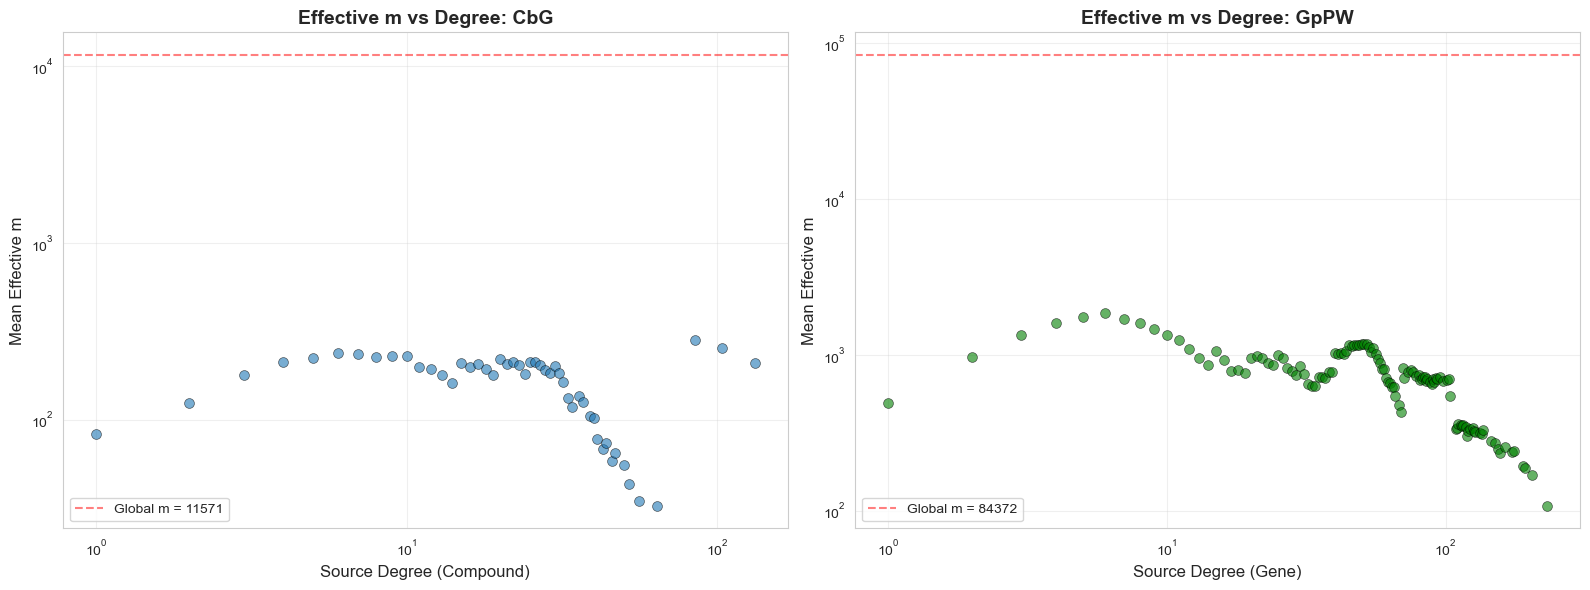


Effective m diagnostic plot saved

Fallback to global m:
  Edge1: 3/3066 (0.1%)
  Edge2: 0/17891 (0.0%)


In [10]:
# Analyze effective m values used in degree-aware model
if diagnostics:
    edge1_m_values = diagnostics['edge1_effective_m']
    edge2_m_values = diagnostics['edge2_effective_m']
    
    print("\nEffective m Diagnostics:")
    print("="*80)
    
    # Edge1 statistics
    edge1_degrees = sorted(set(u for u, v in edge1_m_values.keys()))
    edge1_m_by_degree = defaultdict(list)
    for (u, v), m in edge1_m_values.items():
        edge1_m_by_degree[u].append(m)
    
    print(f"\nEdge1 ({metapath[0]}) - Compound→Gene:")
    print(f"  Unique degree pairs: {len(edge1_m_values)}")
    print(f"  Effective m range: {min(edge1_m_values.values()):.0f} - {max(edge1_m_values.values()):.0f}")
    print(f"  Mean effective m: {np.mean(list(edge1_m_values.values())):.1f}")
    
    # Sample low degrees
    print(f"\n  Sample effective m for low compound degrees:")
    for deg in sorted(edge1_degrees)[:10]:
        m_vals = edge1_m_by_degree[deg]
        print(f"    Degree {deg:2d}: m = {np.mean(m_vals):6.1f} ± {np.std(m_vals):5.1f} (n={len(m_vals)})")
    
    # Edge2 statistics
    edge2_degrees = sorted(set(u for u, v in edge2_m_values.keys()))
    edge2_m_by_degree = defaultdict(list)
    for (u, v), m in edge2_m_values.items():
        edge2_m_by_degree[u].append(m)
    
    print(f"\nEdge2 ({metapath[1]}) - Gene→Pathway:")
    print(f"  Unique degree pairs: {len(edge2_m_values)}")
    print(f"  Effective m range: {min(edge2_m_values.values()):.0f} - {max(edge2_m_values.values()):.0f}")
    print(f"  Mean effective m: {np.mean(list(edge2_m_values.values())):.1f}")
    
    # Visualize effective m vs degree
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Edge1
    ax = axes[0]
    degrees = []
    mean_m = []
    for deg in sorted(edge1_m_by_degree.keys()):
        degrees.append(deg)
        mean_m.append(np.mean(edge1_m_by_degree[deg]))
    
    ax.scatter(degrees, mean_m, alpha=0.6, s=50, edgecolors='black', linewidths=0.5)
    ax.set_xlabel('Source Degree (Compound)', fontsize=12)
    ax.set_ylabel('Mean Effective m', fontsize=12)
    ax.set_title(f'Effective m vs Degree: {metapath[0]}', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    ax.axhline(edge1_het.nnz, color='red', linestyle='--', alpha=0.5, label=f'Global m = {edge1_het.nnz}')
    ax.legend()
    
    # Edge2
    ax = axes[1]
    degrees = []
    mean_m = []
    for deg in sorted(edge2_m_by_degree.keys()):
        degrees.append(deg)
        mean_m.append(np.mean(edge2_m_by_degree[deg]))
    
    ax.scatter(degrees, mean_m, alpha=0.6, s=50, edgecolors='black', linewidths=0.5, color='green')
    ax.set_xlabel('Source Degree (Gene)', fontsize=12)
    ax.set_ylabel('Mean Effective m', fontsize=12)
    ax.set_title(f'Effective m vs Degree: {metapath[1]}', fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(alpha=0.3)
    ax.axhline(edge2_het.nnz, color='red', linestyle='--', alpha=0.5, label=f'Global m = {edge2_het.nnz}')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(results_dir / f'{metapath_name}_effective_m_diagnostics.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nEffective m diagnostic plot saved")
    
    # Check what fraction use global m (fallback)
    global_m_edge1 = sum(1 for m in edge1_m_values.values() if m == edge1_het.nnz)
    global_m_edge2 = sum(1 for m in edge2_m_values.values() if m == edge2_het.nnz)
    
    print(f"\nFallback to global m:")
    print(f"  Edge1: {global_m_edge1}/{len(edge1_m_values)} ({global_m_edge1/len(edge1_m_values)*100:.1f}%)")
    print(f"  Edge2: {global_m_edge2}/{len(edge2_m_values)} ({global_m_edge2/len(edge2_m_values)*100:.1f}%)")
    
else:
    print("\nWarning: Diagnostics not available")

## 7. Null Network Comparison

In [11]:
print(f"\nAnalyzing {len(PERMUTATION_IDS)} null networks...\n")

null_results = []

for perm_id in tqdm(PERMUTATION_IDS, desc="Processing permutations"):
    # Load edges
    edge1_perm = load_edge_matrix(metapath[0], perm_id)
    edge2_perm = load_edge_matrix(metapath[1], perm_id)
    
    # Compute observed
    obs_freq, _, _, _, _ = compute_observed_metapath_frequencies(edge1_perm, edge2_perm)
    
    # Compute predictions
    naive_perm = compute_naive_compositional_model(edge1_perm, edge2_perm)
    da_perm = compute_degree_aware_compositional_model(edge1_perm, edge2_perm)
    
    # Common pairs
    common = set(obs_freq.keys()) & set(naive_perm.keys()) & set(da_perm.keys())
    
    if len(common) > 1:
        y_obs = np.array([obs_freq[p] for p in common])
        y_naive_p = np.array([naive_perm[p] for p in common])
        y_da_p = np.array([da_perm[p] for p in common])
        
        naive_corr_p = pearsonr(y_obs, y_naive_p)[0]
        da_corr_p = pearsonr(y_obs, y_da_p)[0]
        
        null_results.append({
            'perm_id': perm_id,
            'naive_corr': naive_corr_p,
            'degree_aware_corr': da_corr_p,
            'improvement': da_corr_p - naive_corr_p,
            'n_pairs': len(common)
        })

null_df = pd.DataFrame(null_results)

print("\n" + "="*80)
print("NULL NETWORK RESULTS")
print("="*80)

print(f"\nNull Networks (n={len(null_df)}):")
print(f"  Naive correlation:        {null_df['naive_corr'].mean():.4f} ± {null_df['naive_corr'].std():.4f}")
print(f"  Degree-aware correlation: {null_df['degree_aware_corr'].mean():.4f} ± {null_df['degree_aware_corr'].std():.4f}")
print(f"  Mean improvement:         {null_df['improvement'].mean():+.4f} ± {null_df['improvement'].std():.4f}")

print(f"\nHetionet vs Null:")
het_improvement = degree_aware_corr - naive_corr
null_improvement = null_df['improvement'].mean()
print(f"  Hetionet improvement:     {het_improvement:+.4f}")
print(f"  Null improvement:         {null_improvement:+.4f}")
print(f"  Difference:               {het_improvement - null_improvement:+.4f}")

if abs(het_improvement - null_improvement) < 0.01:
    print(f"\n✓ SIMILAR IMPROVEMENT IN HETIONET AND NULL")
    print(f"  → Confirms degree structure is main driver of conditional dependencies")
    print(f"  → Biology adds minimal signal beyond degrees")
else:
    print(f"\n→ DIFFERENT IMPROVEMENT PATTERNS")
    print(f"  → May indicate biological signal beyond degree structure")


Analyzing 5 null networks...



Processing permutations:   0%|          | 0/5 [00:00<?, ?it/s]

  Building degree pair indices...
    Edge1 unique degree pairs: 3008
    Edge2 unique degree pairs: 17868
  Computing degree-aware edge priors...
    Edge1 priors computed: 11571
    Edge2 priors computed: 84372
  Computing compositional probabilities...


Processing permutations:  20%|██        | 1/5 [03:17<13:11, 197.79s/it]

  Building degree pair indices...
    Edge1 unique degree pairs: 3067
    Edge2 unique degree pairs: 17851
  Computing degree-aware edge priors...
    Edge1 priors computed: 11571
    Edge2 priors computed: 84372
  Computing compositional probabilities...


Processing permutations:  40%|████      | 2/5 [06:36<09:55, 198.50s/it]

  Building degree pair indices...
    Edge1 unique degree pairs: 3069
    Edge2 unique degree pairs: 17932
  Computing degree-aware edge priors...
    Edge1 priors computed: 11571
    Edge2 priors computed: 84372
  Computing compositional probabilities...


Processing permutations:  60%|██████    | 3/5 [09:52<06:34, 197.33s/it]

  Building degree pair indices...
    Edge1 unique degree pairs: 3074
    Edge2 unique degree pairs: 17845
  Computing degree-aware edge priors...
    Edge1 priors computed: 11571
    Edge2 priors computed: 84372
  Computing compositional probabilities...


Processing permutations:  80%|████████  | 4/5 [13:10<03:17, 197.62s/it]

  Building degree pair indices...
    Edge1 unique degree pairs: 3065
    Edge2 unique degree pairs: 17854
  Computing degree-aware edge priors...
    Edge1 priors computed: 11571
    Edge2 priors computed: 84372
  Computing compositional probabilities...


Processing permutations: 100%|██████████| 5/5 [16:28<00:00, 197.66s/it]


NULL NETWORK RESULTS

Null Networks (n=5):
  Naive correlation:        0.0595 ± 0.0076
  Degree-aware correlation: 0.0499 ± 0.0125
  Mean improvement:         -0.0095 ± 0.0068

Hetionet vs Null:
  Hetionet improvement:     +0.0073
  Null improvement:         -0.0095
  Difference:               +0.0169

→ DIFFERENT IMPROVEMENT PATTERNS
  → May indicate biological signal beyond degree structure


## 8. Visualizations

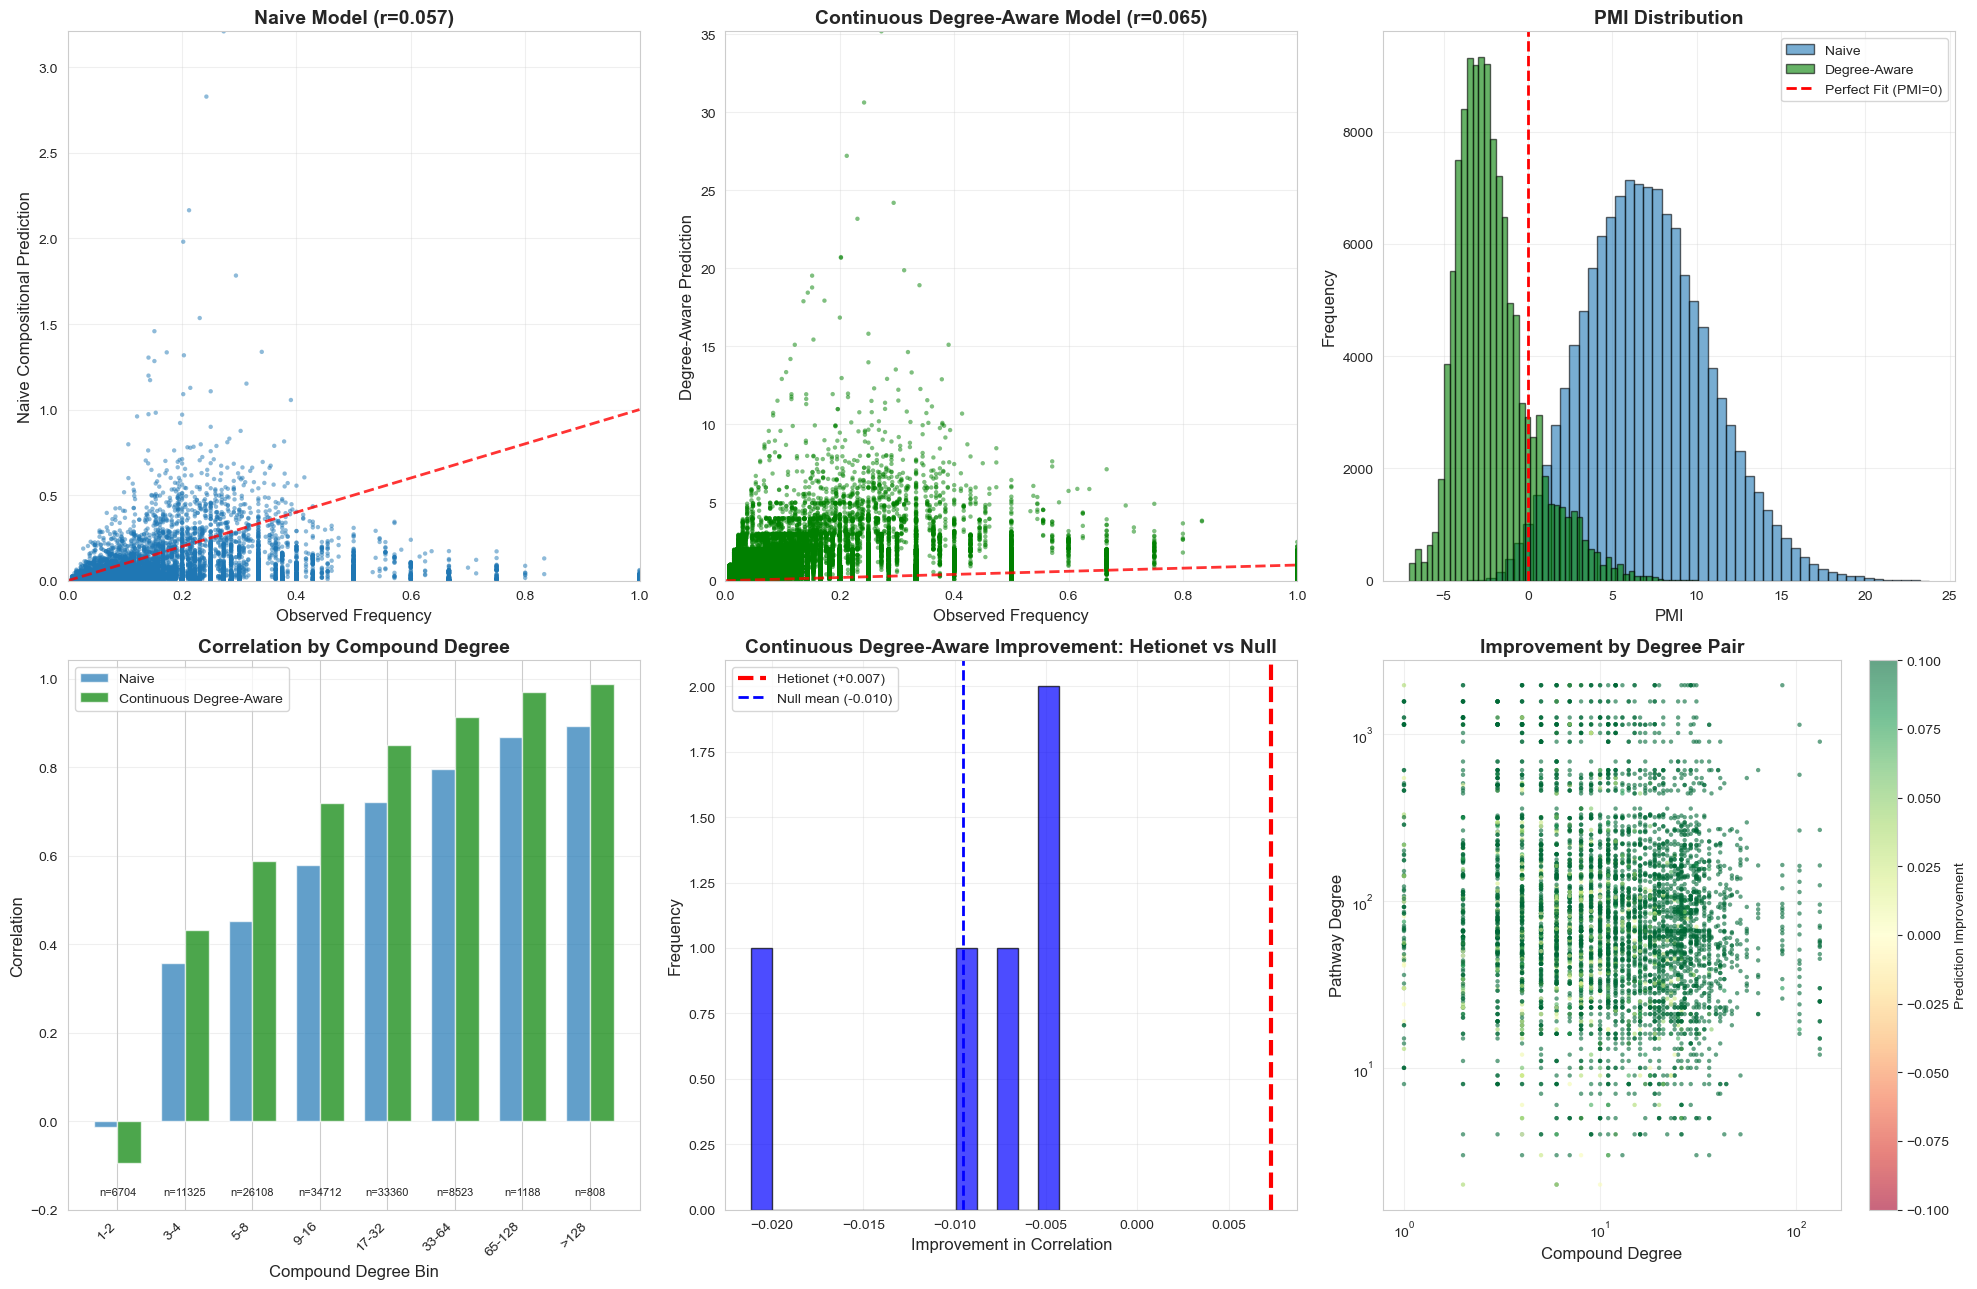


Visualization saved to: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/degree_aware_compositionality/CbGpPW_degree_aware_analysis.png


In [12]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 13))

# 1. Scatter: Observed vs Naive
ax = axes[0, 0]
ax.scatter(y_true, y_naive, alpha=0.5, s=10, edgecolors='none')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.8, linewidth=2)
ax.set_xlabel('Observed Frequency', fontsize=12)
ax.set_ylabel('Naive Compositional Prediction', fontsize=12)
ax.set_title(f'Naive Model (r={naive_corr:.3f})', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, max(y_naive.max(), 1))

# 2. Scatter: Observed vs Degree-Aware
ax = axes[0, 1]
ax.scatter(y_true, y_degree_aware, alpha=0.5, s=10, edgecolors='none', color='green')
ax.plot([0, 1], [0, 1], 'r--', alpha=0.8, linewidth=2)
ax.set_xlabel('Observed Frequency', fontsize=12)
ax.set_ylabel('Degree-Aware Prediction', fontsize=12)
ax.set_title(f'Continuous Degree-Aware Model (r={degree_aware_corr:.3f})', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, max(y_degree_aware.max(), 1))

# 3. PMI distributions
ax = axes[0, 2]
ax.hist(pmi_naive, bins=50, alpha=0.6, label='Naive', edgecolor='black')
ax.hist(pmi_degree_aware, bins=50, alpha=0.6, label='Degree-Aware', edgecolor='black', color='green')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Fit (PMI=0)')
ax.set_xlabel('PMI', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('PMI Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 4. Correlation by compound degree (using visualization bins)
ax = axes[1, 0]
corr_by_compound = []
for bin_label in DEGREE_LABELS_VIZ:
    subset = results_df[results_df['compound_bin'] == bin_label]
    if len(subset) > 10:
        naive_c = pearsonr(subset['observed'], subset['naive_pred'])[0]
        da_c = pearsonr(subset['observed'], subset['degree_aware_pred'])[0]
        corr_by_compound.append({
            'bin': bin_label, 
            'naive': naive_c, 
            'degree_aware': da_c,
            'n': len(subset)
        })

if corr_by_compound:
    corr_compound_df = pd.DataFrame(corr_by_compound)
    x = np.arange(len(corr_compound_df))
    width = 0.35
    bars1 = ax.bar(x - width/2, corr_compound_df['naive'], width, label='Naive', alpha=0.7)
    bars2 = ax.bar(x + width/2, corr_compound_df['degree_aware'], width, label='Continuous Degree-Aware', alpha=0.7, color='green')
    
    # Add sample size annotations
    for i, row in corr_compound_df.iterrows():
        ax.text(i, -0.15, f"n={row['n']}", ha='center', va='top', fontsize=8, rotation=0)
    
    ax.set_xlabel('Compound Degree Bin', fontsize=12)
    ax.set_ylabel('Correlation', fontsize=12)
    ax.set_title('Correlation by Compound Degree', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(corr_compound_df['bin'], rotation=45, ha='right')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    ax.set_ylim(bottom=-0.2)

# 5. Null network improvement distribution
ax = axes[1, 1]
ax.hist(null_df['improvement'], bins=15, alpha=0.7, edgecolor='black', color='blue')
ax.axvline(het_improvement, color='red', linestyle='--', linewidth=3, label=f'Hetionet ({het_improvement:+.3f})')
ax.axvline(null_improvement, color='blue', linestyle='--', linewidth=2, label=f'Null mean ({null_improvement:+.3f})')
ax.set_xlabel('Improvement in Correlation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Continuous Degree-Aware Improvement: Hetionet vs Null', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 6. Performance vs compound degree (scatter)
ax = axes[1, 2]
# Sample if too many points
if len(results_df) > 5000:
    sample_df = results_df.sample(5000, random_state=42)
else:
    sample_df = results_df

# Color by improvement
improvement = sample_df['degree_aware_pred'] - sample_df['naive_pred']
scatter = ax.scatter(sample_df['compound_degree'], sample_df['pathway_degree'], 
                     c=improvement, cmap='RdYlGn', alpha=0.6, s=10, 
                     vmin=-0.1, vmax=0.1, edgecolors='none')
ax.set_xlabel('Compound Degree', fontsize=12)
ax.set_ylabel('Pathway Degree', fontsize=12)
ax.set_title('Improvement by Degree Pair', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Prediction Improvement', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / f'{metapath_name}_degree_aware_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {results_dir / f'{metapath_name}_degree_aware_analysis.png'}")

## 9. Save Results

In [13]:
# Save Hetionet results
results_df.to_csv(results_dir / f'{metapath_name}_hetionet_results.csv', index=False)

# Save null results
null_df.to_csv(results_dir / f'{metapath_name}_null_results.csv', index=False)

# Save summary
summary = {
    'metapath': metapath_name,
    'hetionet_naive_corr': naive_corr,
    'hetionet_degree_aware_corr': degree_aware_corr,
    'hetionet_improvement': het_improvement,
    'hetionet_naive_rmse': naive_rmse,
    'hetionet_degree_aware_rmse': degree_aware_rmse,
    'hetionet_naive_pmi_mean': pmi_naive.mean(),
    'hetionet_degree_aware_pmi_mean': pmi_degree_aware.mean(),
    'null_naive_corr_mean': null_df['naive_corr'].mean(),
    'null_degree_aware_corr_mean': null_df['degree_aware_corr'].mean(),
    'null_improvement_mean': null_improvement,
    'n_hetionet_pairs': len(common_pairs),
    'n_null_networks': len(null_df)
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv(results_dir / f'{metapath_name}_summary.csv', index=False)

print(f"\nResults saved to:")
print(f"  - {results_dir / f'{metapath_name}_hetionet_results.csv'}")
print(f"  - {results_dir / f'{metapath_name}_null_results.csv'}")
print(f"  - {results_dir / f'{metapath_name}_summary.csv'}")


Results saved to:
  - /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/degree_aware_compositionality/CbGpPW_hetionet_results.csv
  - /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/degree_aware_compositionality/CbGpPW_null_results.csv
  - /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/degree_aware_compositionality/CbGpPW_summary.csv


## 10. Conclusions

In [14]:
print("\n" + "="*80)
print("CONCLUSIONS: DEGREE-AWARE COMPOSITIONAL MODELING")
print("="*80)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   Naive compositional:      r = {naive_corr:.4f}")
print(f"   Degree-aware:             r = {degree_aware_corr:.4f}")
print(f"   Improvement:              Δr = {het_improvement:+.4f} ({het_improvement / abs(naive_corr) * 100:+.1f}%)")

if het_improvement > 0.01:
    print(f"\n   ✓ DEGREE-AWARE MODEL SIGNIFICANTLY IMPROVES FIT")
elif het_improvement > 0:
    print(f"\n   → Modest improvement from degree stratification")
else:
    print(f"\n   ✗ No improvement or degradation")

print(f"\n2. PMI REDUCTION:")
print(f"   Naive PMI:                {pmi_naive.mean():.4f}")
print(f"   Degree-aware PMI:         {pmi_degree_aware.mean():.4f}")
print(f"   Reduction:                {pmi_naive.mean() - pmi_degree_aware.mean():.4f}")

if abs(pmi_degree_aware.mean()) < abs(pmi_naive.mean()):
    print(f"\n   ✓ PMI closer to 0 → better compositional fit")

print(f"\n3. HETIONET VS NULL:")
print(f"   Hetionet improvement:     {het_improvement:+.4f}")
print(f"   Null improvement (mean):  {null_improvement:+.4f}")
print(f"   Difference:               {abs(het_improvement - null_improvement):.4f}")

if abs(het_improvement - null_improvement) < 0.01:
    print(f"\n   ✓ SIMILAR IMPROVEMENT (difference < 0.01)")
    print(f"     → Degree structure is primary driver")
    print(f"     → Biological dependencies are minimal")
else:
    print(f"\n   → DIFFERENT IMPROVEMENT PATTERNS")
    print(f"     → Potential biological signal beyond degrees")

print(f"\n4. RECOMMENDATIONS:")

if het_improvement > 0.05 and abs(het_improvement - null_improvement) < 0.02:
    print(f"   → USE DEGREE-AWARE COMPOSITIONAL MODELS")
    print(f"   → Substantial improvement from degree stratification")
    print(f"   → Apply to both Hetionet and null networks")
    print(f"   → Stratify by {len(DEGREE_BINS)-1} degree bins: {DEGREE_LABELS}")
elif het_improvement > 0:
    print(f"   → DEGREE-AWARE MODELS PROVIDE MODEST BENEFIT")
    print(f"   → Consider simpler degree-correction methods")
    print(f"   → May not be worth added complexity")
else:
    print(f"   → DEGREE STRATIFICATION NOT HELPFUL")
    print(f"   → Use naive compositional or ML approaches")

if abs(het_improvement - null_improvement) > 0.02:
    print(f"\n   → BIOLOGICAL SIGNAL DETECTED")
    print(f"   → Consider hybrid: degree-aware + biological corrections")
    print(f"   → ML models may capture additional structure")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")


CONCLUSIONS: DEGREE-AWARE COMPOSITIONAL MODELING

1. MODEL PERFORMANCE:
   Naive compositional:      r = 0.0572
   Degree-aware:             r = 0.0645
   Improvement:              Δr = +0.0073 (+12.8%)

   → Modest improvement from degree stratification

2. PMI REDUCTION:
   Naive PMI:                7.1106
   Degree-aware PMI:         -2.0345
   Reduction:                9.1451

   ✓ PMI closer to 0 → better compositional fit

3. HETIONET VS NULL:
   Hetionet improvement:     +0.0073
   Null improvement (mean):  -0.0095
   Difference:               0.0169

   → DIFFERENT IMPROVEMENT PATTERNS
     → Potential biological signal beyond degrees

4. RECOMMENDATIONS:
   → DEGREE-AWARE MODELS PROVIDE MODEST BENEFIT
   → Consider simpler degree-correction methods
   → May not be worth added complexity

ANALYSIS COMPLETE
